# Introduction

* The goal of this project is use Deep Learning regression technique to predict 
the estimated price of a stock market which is benificial for making profitable trading or investing decision.


* For simplicity, we train 2 models: one to predict the **"High" (highest)** price and another to predict the **"Low" (lowest)** price of the stock. We are for now only interested on the "High" and "Low" price because we think that these 2 prices are 2 of the most importants factors to make buying or selling decision. For example, If we can predict the high (highest) price for tommorrow and if it is higher than the current price, we can make a buying position and sell it at the highest price that we predicted. Off course, we might not sell exactly at the price that we predicted. We might sell at a bit lower or higher price depending the risk that we want to take. Similarly, if we can predict the low (lowest) price for tommorrow and it is lower than the current price, we can make sell position and buy it back at the lowest price that we predicted. In both cases, we make profit.


* We use **LSTM (Long short-term memory) Deep Learning model**, one of the simplest but promissing (showing signs of future success)  model in predicting time serie data. And we train our model on the **Tesla stock market**, one the biggest US maket. 

* We decide to focus/train the model only on the data after 2019. ***Why ?*** Because it is the year that COVID 19 started and impacts the world economy. So, the distribution/behavior of the data (maket price) is particulary different from the distribution/behavior of the data before 2019. If we include the data before 2019, our trained model might not well reflect the current situation (COVID 19 and the war in UKRAINE). 


In [1]:
# Import librairies
%matplotlib inline 
import matplotlib.pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [40, 18]
plt.rcParams['lines.linewidth'] = 1

# Importing the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/ML 2nd semester/tesla_stocks 2010-2022.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2022-03-16,2022-03-16,809.000000,842.000000,802.260010,840.229980,840.229980,28009600
2022-03-17,2022-03-17,830.989990,875.000000,825.719971,871.599976,871.599976,22194300
2022-03-18,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2022-03-23,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2022-03-24,2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22973600
2022-03-25,2022-03-25,1008.000000,1021.799988,997.320007,1010.640015,1010.640015,20642900
2022-03-28,2022-03-28,1065.099976,1097.880005,1053.599976,1091.839966,1091.839966,34044700


# Plotting the data
Plotting the data is the first and very important step before training the model. It let us see the shape and the trend of the data which are the decision factors for choosing the right model.




In [4]:
def plot_graph(data,lbl):
    fig, ax = plt.subplots(figsize=(20,9))

    ax.plot(data.index, data, label=lbl)
    ax.set_xlabel('Date')
    ax.set_ylabel(lbl)
    ax.legend()

    plt.show()

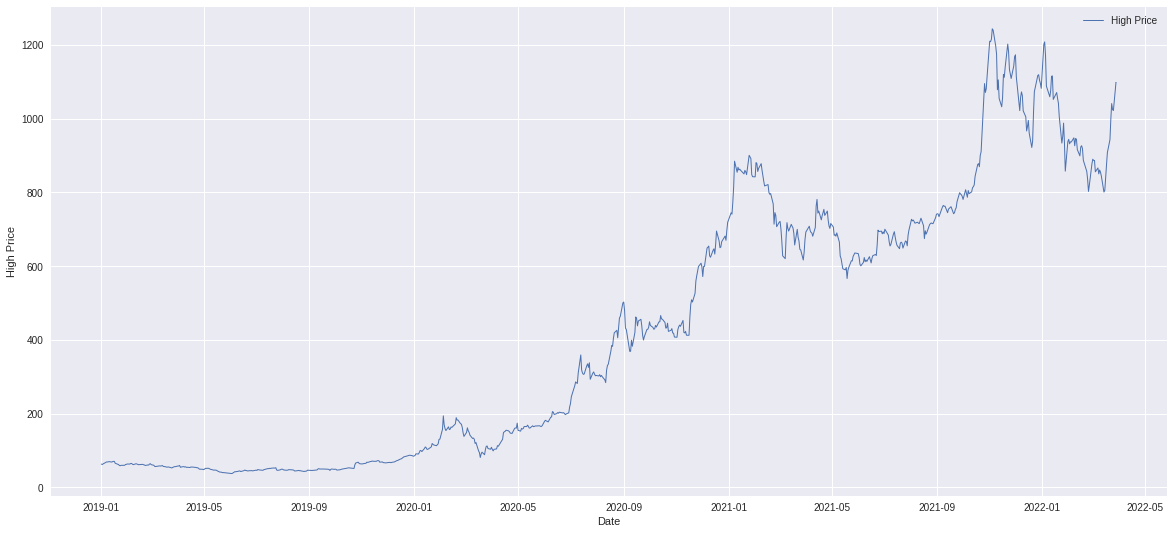

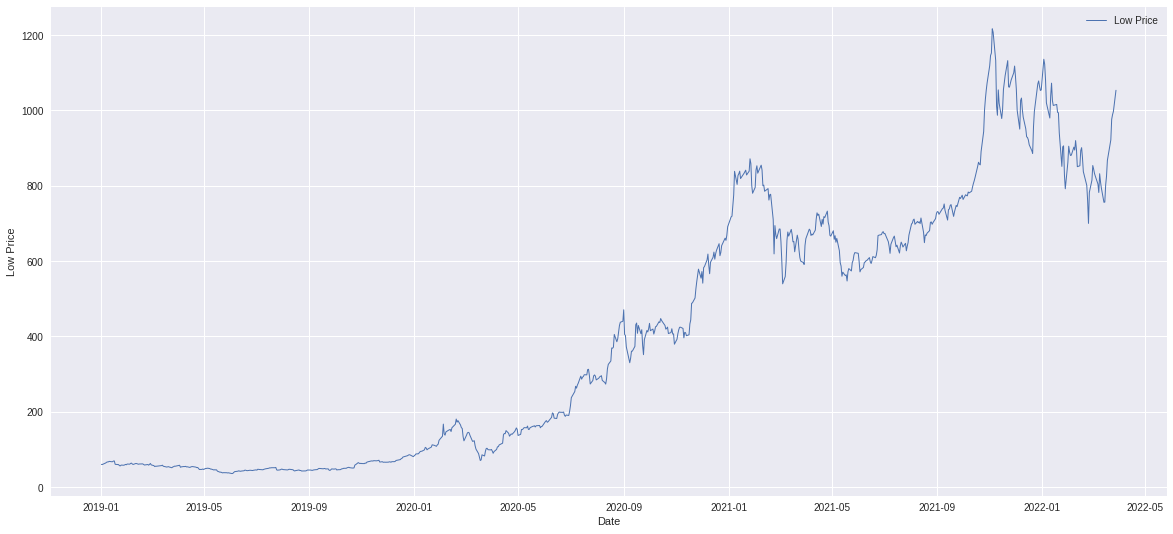

In [24]:
# we plot the graph of the High and Low Price 
plot_graph(data=df[df.index>'2019-01-01'].High,lbl='High Price')    
plot_graph(data=df[df.index>'2019-01-01'].Low,lbl='Low Price')    


# Train the models with LSTM

The train interval is [01/01/2019 - 12/31/2021]
The test interval is [01/01/2022 - END]


In [6]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
import math

In [7]:
# Window size = number of previous values to predict the next value # To limit the interval 
WINDOW_SIZE = 10

In [8]:
# Generate sequences of lenght = WINDOW_SIZE

def generateSequence(sequence,backward):
    X, y = list(), list()
    for i in range(sequence.shape[0]-backward):
        seq_x, seq_y = sequence[i:i+backward], sequence[i+backward]
        X.append(seq_x)
        y.append(seq_y)
    X=np.array(X)
    y=np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X,y

## Model to predict the High price


### Data Pre-processing 

In [9]:
train_high = df.High[(df.index>'2019-01-01') & (df.index<'2021-12-31')].values.reshape(-1, 1)
all_high = df.High[df.index>'2019-01-01'].values.reshape(-1, 1)

#  MinMaxScaler
scaler = MinMaxScaler()
scaled_all_high = scaler.fit_transform(all_high)
scaled_train_high = scaler.transform(train_high)                     

print("Train shape = {}".format(scaled_train_high.shape))
print("All shape = {}".format(scaled_all_high.shape))
print("nan values ? {}".format(np.isnan(scaled_train_high).any()))

Train shape = (756, 1)
All shape = (817, 1)
nan values ? False


### Generate sequences

In [10]:

X,y = generateSequence(scaled_train_high,WINDOW_SIZE)
num_train_sequences = X.shape[0]
print("X shape = {}".format(X.shape))
print("y shape = {}".format(y.shape))


X shape = (746, 10, 1)
y shape = (746, 1)


### Build the model

In [11]:
model = Sequential()
model.add(LSTM(12, activation='relu', input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

###  Training

In [12]:
#  Compile
model.compile(
    loss='mse', 
    optimizer='adam'
)

BATCH_SIZE = 64

#  Compile
history = model.fit(
    X, 
    y, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)


Epoch 1/50
11/11 [==============================] - 2s 24ms/step - loss: 0.0617 - val_loss: 0.3563
Epoch 2/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0454 - val_loss: 0.2778
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0318 - val_loss: 0.2035
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.1371
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0829
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0448
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0212
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0114
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 11/50
11/11

24/24 [==============================] - 0s 2ms/step - loss: 8.6096e-04
Train Score: 0.000861 MSE (0.029342 RMSE)


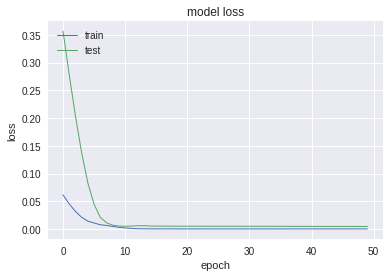

In [13]:
trainScore = model.evaluate(X, y)
print('Train Score: %.6f MSE (%.6f RMSE)' % (trainScore, math.sqrt(trainScore)))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

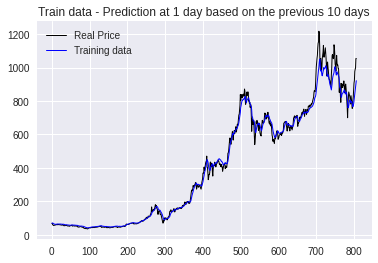

In [25]:
y_train_predicted = model.predict(X)
y_inverse = scaler.inverse_transform(y)
y_train_predicted_inverse = scaler.inverse_transform(y_train_predicted)


plt.plot(y_inverse.ravel(), label="Real Price", color='black')
plt.plot(y_train_predicted_inverse.ravel(), label="Training data", color='blue')
plt.legend(loc='upper left')
plt.title("Train data - Prediction at 1 day based on the previous {} days".format(WINDOW_SIZE))
plt.show()

### Prediction for all the data





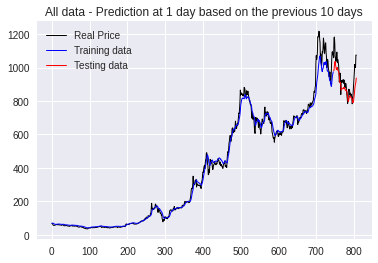

In [26]:
X,y = generateSequence(scaled_all_high,WINDOW_SIZE)

y_predicted = model.predict(X)
y_inverse = scaler.inverse_transform(y)
y_predicted_inverse = scaler.inverse_transform(y_predicted)
num_all_sequences=y_predicted_inverse.shape[0]


plt.plot(y_inverse.ravel(), label="Real Price", color='black')
plt.plot(pd.Series(y_predicted_inverse[:num_train_sequences].ravel(),index=range(0,num_train_sequences)), label="Training data", color='blue')
plt.plot(pd.Series(y_predicted_inverse[num_train_sequences:].ravel(),index=range(num_train_sequences,num_all_sequences)), label="Testing data", color='red')

plt.legend(loc='upper left')
plt.title("All data - Prediction at 1 day based on the previous {} days".format(WINDOW_SIZE))
plt.show()

### Evaluation

In [17]:
# calculate the MSE of the prediction 
mse_prediction = np.mean(np.square(y_predicted[num_train_sequences:-1] - y[num_train_sequences:-1]))
print("Prediction Mean Square Error: ", mse_prediction)

Prediction Mean Square Error:  0.003382595940832885


## Model to predict the Low price

### Data Pre-processing 

In [18]:
train_low = df.Low[(df.index>'2019-01-01') & (df.index<'2021-12-31')].values.reshape(-1, 1)
all_low = df.Low[df.index>'2019-01-01'].values.reshape(-1, 1)

#  MinMaxScaler
scaler = MinMaxScaler()
scaled_all_low = scaler.fit_transform(all_low)
scaled_train_low = scaler.transform(train_low)                     

print("Train shape = {}".format(scaled_train_low.shape))
print("All shape = {}".format(scaled_all_low.shape))
print("nan values ? {}".format(np.isnan(scaled_train_low).any()))

Train shape = (756, 1)
All shape = (817, 1)
nan values ? False


### Generate sequences

In [19]:
X,y = generateSequence(scaled_train_low,WINDOW_SIZE)
num_train_sequences = X.shape[0]
print("X shape = {}".format(X.shape))
print("y shape = {}".format(y.shape))

X shape = (746, 10, 1)
y shape = (746, 1)


### Build the model


In [20]:
model = Sequential()
model.add(LSTM(12, activation='relu', input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

### Training

In [21]:
#  Compile
model.compile(
    loss='mse', 
    optimizer='adam'
)

BATCH_SIZE = 64

#  Compile
history = model.fit(
    X, 
    y, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
11/11 [==============================] - 1s 23ms/step - loss: 0.1073 - val_loss: 0.6192
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0942 - val_loss: 0.5707
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0847 - val_loss: 0.5297
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0773 - val_loss: 0.4975
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0707 - val_loss: 0.4691
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0648 - val_loss: 0.4409
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0593 - val_loss: 0.4142
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0541 - val_loss: 0.3881
Epoch 9/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0485 - val_loss: 0.3626
Epoch 10/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0431 - val_loss: 0.3374
Epoch 11/50
11/

### Prediction for all the data

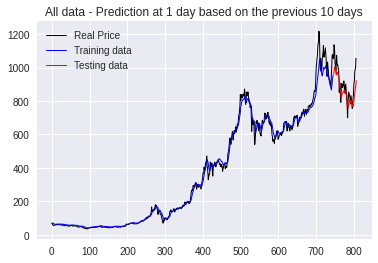

In [27]:
X,y = generateSequence(scaled_all_low,WINDOW_SIZE)

y_predicted = model.predict(X)
y_inverse = scaler.inverse_transform(y)
y_predicted_inverse = scaler.inverse_transform(y_predicted)
num_all_sequences=y_predicted_inverse.shape[0]


plt.plot(y_inverse.ravel(), label="Real Price", color='black')
plt.plot(pd.Series(y_predicted_inverse[:num_train_sequences].ravel(),index=range(0,num_train_sequences)), label="Training data", color='blue')
plt.plot(pd.Series(y_predicted_inverse[num_train_sequences:].ravel(),index=range(num_train_sequences,num_all_sequences)), label="Testing data", color='red')

plt.legend(loc='upper left')
plt.title("All data - Prediction at 1 day based on the previous {} days".format(WINDOW_SIZE))
plt.show()

### Evaluation

In [23]:
# calculate the MSE of the prediction 
mse_prediction = np.mean(np.square(y_predicted[num_train_sequences:-1] - y[num_train_sequences:-1]))
print("Prediction Mean Square Error: ", mse_prediction)

Prediction Mean Square Error:  0.003126094234890772


# Conclusion

From the prediction plots, we can see that both models predict faily well the price before 2022 but it does not predict exactly quite well the correct prices for the first 4 months of 2022. Although some different between the true prices and the predicted prices, but if we look at the trend, the predicted prices follow the same trends of the true prices. 

Predicting the maket behavior from 2019 is quite challenging. The world economic have been heavily impacted by the COVID 19 and recently by the war in UKRAINE. The behovior of the economic actors (people) changed because everything is uncertain and the market is quite unpredictable. 